<a href="https://colab.research.google.com/github/ValentinCord/HandOnAI_1/blob/main/Fire_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://keras.io/api/applications/

|Model|Size (MB)|	Top-1 Accuracy|	Parameters|	Depth|	Time (ms) inference (GPU)|
|---|---|---|---|---|---|
|MobileNet|	16|	70.4%|4.3M|	55	|	3.4|
|Xception|	88|	79%	|22.9M|	81|		8.1|
|InceptionResNetV2|	215	|80.3%|	55.9M|	449|		10.0|
|EfficientNetB6|	166|	84.0%	|43.3M|	360	|40.4|

In [1]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [2]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.2 MB/s 


In [3]:
import numpy as np 
import os
import cv2
import csv
import math
import argparse
import matplotlib
import imghdr
import pickle as pkl
import datetime

from IPython.display import Image, HTML, display
from matplotlib import pyplot as plt
from cycler import cycler
from PIL import Image, ImageEnhance
from google.colab import files

# For Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception, preprocess_input, decode_predictions #299*299
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions #224*224

from keras.applications.densenet import DenseNet201

from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Tensorflow Explicability
import tf_explain
%load_ext tensorboard

print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


In [ ]:
def check_images( s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/gdrive/MyDrive'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print (bad_file_list[i])
        os.remove(bad_file_list[i])
else:
    print(' no improper image files were found')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

drive_data_folder = '/content/gdrive/MyDrive/HandOnAI_1_Fire/'

Mounted at /content/gdrive


In [5]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

In [6]:
configs = dict(
      nb_classes = 3,                         # fire, no_fire, start_fire
      batch_size = 64,                         # computed images before backpropagation
      input_dim = 224,                        # size of the input depending of the backbone
      epochs = 10,                             
      dataset_name = drive_data_folder,       # dataset loaded from google.drive
      classifier = "DenseNet",                # select the backbone
      pretrain_weights = 'imagenet',
      init_learning_rate = 0.001,
      lr_decay_rate = 0.1,
      optimizer = 'adam',                      # SGD, Adam, RMSprop
      loss_fn = 'categorical_crossentropy',   
      metrics = ['acc'],
      earlystopping_patience = 5,
      seed = 42,
      validation_split = 0.2
    )

tf.keras.utils.set_random_seed(configs['seed']) # Fixe seed to get more stable results

classes_path = 'classes.txt'
csv_path = 'result.csv'
#dataset_path = 'bases'
result_path = 'results/' + configs['classifier']
#dataset_path = os.path.join('bases/', configs['dataset_name'])
result_path='results/'
log_path='logs'
result_path = 'results/' + configs['classifier']

In [7]:
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

print(f'Classes : {classes}')
print(f'Number of classes : {num_classes}')

Classes : ['fire', 'no_fire', 'start_fire']
Number of classes : 3


In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	configs['dataset_name'],          																		  # Path of the dataset
	validation_split = configs['validation_split'],             						# Data division : validation (20%), train (80%)
	subset = 'training',                																		# Selection of training data
	seed = configs['seed'],                          												# Initialization of random generator (for permutations)
	image_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images
	batch_size = configs['batch_size'],																			# Batch_size
  label_mode = 'categorical'     																					# Conversion to One-Hot format
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	configs['dataset_name'],          																		  # Path of the dataset
	validation_split = configs['validation_split'],             						# Data division : validation (20%), train (80%)
	subset = 'validation',              																		# Selection of validation data
	seed = configs['seed'],                         												# Initialization of random generator (for permutations)
	image_size = (configs['input_dim'], configs['input_dim']),    					# Input size of images
	batch_size = configs['batch_size'], 																		# Batch_size
  label_mode = 'categorical'     																					# Conversion to One-Hot format
)

Found 1869 files belonging to 3 classes.
Using 1496 files for training.
Found 1869 files belonging to 3 classes.
Using 373 files for validation.


In [9]:
def build_model():

  base_model = DenseNet201(
      include_top = False, 
      weights ='imagenet', 
      input_shape = (configs['input_dim'], configs['input_dim'],3))

  model = base_model.output
  model = Flatten()(model)
  model = Dense(128, activation='relu')(model)
  model = Dropout(0.8)(model)
  model = Dense(64, activation = 'relu',  name="layer2")(model)
  model = Dropout(0.4)(model)
  
  predictions = Dense(3, activation = 'softmax')(model)

  model = Model(inputs=base_model.inputs, outputs = predictions)

  return model

74836368/74836368 [==============================] - 0s 0us/step
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.569782 to fit



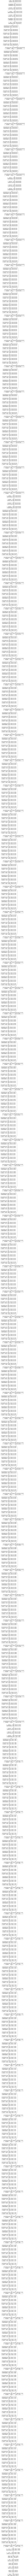

In [10]:
model = build_model()
#model.summary()
tf.keras.utils.plot_model(
    model,
    to_file = 'model_summary.png',
    show_shapes = True,                 # show size of the layer
    show_dtype = False,                        
    show_layer_names = True,
    rankdir = 'TB',                     # TB : vertical ; LR : horizontal
    expand_nested = False,
    dpi = 70,                           # size of the graph
    layer_range = None,                 # pass a list of the first and the last layer to draw
    show_layer_activations = True       # show activation function type
)

In [11]:
def train(config: dict, callbacks: list, verbose: int=0):
  
  tf.keras.backend.clear_session()                  # https://stackoverflow.com/questions/57731214/what-tf-keras-backend-clear-session-actually-do
  
  model = build_model()

  # Select layers to be trained
  for layer in model.layers:
      layer.trainable = False                       # Freeze all the model
  
  for layer in model.layers[:-5]:
      layer.trainable = True


  # recompiler le modèle
  opt = keras.optimizers.SGD(learning_rate=config['init_learning_rate'])
  opt2 = keras.optimizers.Adam(learning_rate=config['init_learning_rate'])
  opt3 = keras.optimizers.RMSprop(learning_rate=config['init_learning_rate'])

  model.compile(loss=config['loss_fn'],optimizer=opt2,metrics=config['metrics'])  


  # Création du dossier pour sauvegrader le model
  if os.path.exists(result_path) == False:
      os.makedirs(result_path)

  # keras_callback = [EarlyStopping(monitor='val_loss',patience = config['earlystopping_patience'], mode='auto',restore_best_weights=True)]
  history = model.fit(
      train_ds,
      steps_per_epoch=math.ceil(len(train_ds)),
      epochs=config['epochs'],
      validation_data=val_ds,
      validation_steps=math.ceil(len(val_ds)),
      callbacks = callbacks
  )
  return model, history

In [12]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs/', histogram_freq=1)

In [ ]:
callbacks = [tensorboard_callback]

# Train
!rm -rf logs
model, history = train(configs, callbacks, 1)

# Evaluate the trained model
loss, acc = model.evaluate(val_ds)

Epoch 1/10


In [ ]:
model.save('test.h5')

In [ ]:
files.upload();

In [ ]:
%matplotlib inline
image_path = "fog.jpg"
img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(224,224))
x = np.expand_dims(x, axis=0)
# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
%tensorboard --logdir logs